# WeatherML

## Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [6]:
COLOR_MAPPING = {
    'none': 'red',
    'jacket-short': 'orange',
    'jacket-long': 'green',
    'coat': 'blue'
}

RANDOM_STATE = 17

## Data Processing

In [7]:
df = pd.read_csv('data/weather_data.csv')
print('# Records:', df.shape[0])
print('# Features:', df.shape[1])
df.head()

# Records: 630
# Features: 9


,Date,Time,Temp (°F),Feels Like (°F),Humidity (%),UV,Wind (mph),Gusts (mph),Outer Clothing
0,07/11/2023,13:55,80,80,44,9,4,NaN,none
1,07/12/2023,12:44,83,83,45,9,4,NaN,none
2,07/13/2023,20:15,75,78,79,0,4,NaN,none
3,07/17/2023,17:38,82,83,49,3,5,NaN,none
4,07/22/2023,18:03,75,76,58,2,4,NaN,none


### Season Data

In [8]:
def get_season(date_str: str) -> str:
    date = datetime.strptime(date_str, '%m/%d/%Y')
    if date.month in [12, 1, 2]:
        return 'Winter'
    elif date.month in [3, 4, 5]:
        return 'Spring'
    elif date.month in [6, 7, 8]:
        return 'Summer'
    elif date.month in [9, 10, 11]:
        return 'Fall'

df['Season'] = [get_season(date_str) for date_str in df['Date']]

## Data Analysis & Visualizations

### Target Class Distribution

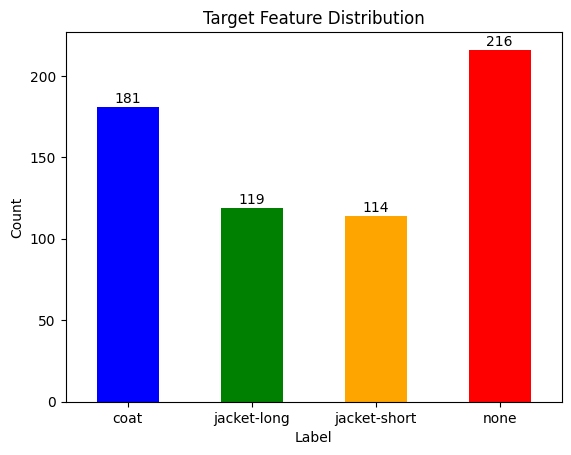

In [9]:
label_distr = df['Outer Clothing'].value_counts().sort_index()
colors = [COLOR_MAPPING[label] for label in label_distr.index]

ax = label_distr.plot(kind='bar', color=colors)
for i, count in enumerate(label_distr):
    ax.text(i, count + 5, f'{label_distr.iloc[i]}', ha='center', va='center')

plt.title('Target Feature Distribution')
plt.xticks(rotation=0)
plt.xlabel('Label')
plt.ylabel('Count');

## Machine Learning Models